<h1>Trabajo final de Diseño de Sistemas Inteligentes: KDD 2010</h1>

Autores: Pablo León Alcaide y Marcos Ludeña Triviño

In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import lightgbm as lgb

from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import zipfile
import os
import gc

np.random.seed(2018)

Carga de los datos

In [2]:
train = pd.read_csv('data/algebra_2008_2009/algebra_2008_2009_train.txt', sep='\t')#, skiprows=skiprows)
test = pd.read_csv('data/algebra_2008_2009/algebra_2008_2009_test.txt', sep='\t')
sub = pd.read_csv('data/algebra_2008_2009/algebra_2008_2009_submission.txt', sep='\t')

train.head(n=3)

Row Anon Student Id                Problem Hierarchy Problem Name  \
0    1  stu_de2777346f  Unit CTA1_01, Section CTA1_01-3      REAL20B   
1    2  stu_de2777346f  Unit CTA1_01, Section CTA1_01-3      REAL20B   
2    3  stu_de2777346f  Unit CTA1_01, Section CTA1_01-3      REAL20B   

   Problem View Step Name        Step Start Time First Transaction Time  \
0             1      R2C1  2008-09-19 13:30:46.0  2008-09-19 13:30:46.0   
1             1      R3C1  2008-09-19 13:30:46.0  2008-09-19 13:30:46.0   
2             1      R3C2  2008-09-19 13:30:46.0  2008-09-19 13:30:46.0   

  Correct Transaction Time          Step End Time        ...          \
0    2008-09-19 13:30:46.0  2008-09-19 13:30:46.0        ...           
1    2008-09-19 13:30:46.0  2008-09-19 13:30:46.0        ...           
2    2008-09-19 13:30:46.0  2008-09-19 13:30:46.0        ...           

   Correct First Attempt  Incorrects  Hints  Corrects  \
0                      0           3      1         1   
1                      1           0      0         1   
2                      1           0      0         1   

                                       KC(SubSkills)  Opportunity(SubSkills)  \
0                                  Identifying units                       1   
1                                    Define Variable                       1   
2  Write expression, any form~~Using simple numbe...        1~~1~~1~~1~~1~~1   

                                   KC(KTracedSkills)  \
0                                                NaN   
1                                                NaN   
2  Using simple numbers-1~~Using large numbers-1~...   

  Opportunity(KTracedSkills)                   KC(Rules) Opportunity(Rules)  
0                        NaN                   UNIT-HELP                  1  
1                        NaN               VARIABLE-HELP                  1  
2                    1~~1~~1  STANDARD-MX+B-FORMULA-HELP                  1  

[3 rows x 23 columns]

Renombrado de las columnas para facilitar el trabajo posterior

In [3]:
rename_dict = {
    'Row': 'row',
    'Anon Student Id': 'student_id', 
    'Problem Hierarchy': 'problem_hierarchy', 
    'Problem Name': 'problem_name',
    'Problem View': 'problem_view', 
    'Step Name': 'step_name', 
    'Step Start Time': 'step_start_time',
    'First Transaction Time': 'first_transaction_time', 
    'Correct Transaction Time': 'correct_transacion_time',
    'Step End Time': 'step_end_time',
    'Step Duration (sec)': 'step_duration',
    'Correct Step Duration (sec)': 'correct_step_duration',
    'Error Step Duration (sec)': 'error_step_duration', 
    'Correct First Attempt': 'correct_first_attempt', 
    'Incorrects': 'incorrects',
    'Hints': 'hints', 
    'Corrects': 'corrects',
    'KC(SubSkills)': 'kc_subskills', 
    'Opportunity(SubSkills)': 'opp_subskills',
    'KC(KTracedSkills)': 'kc_ktracedskills',
    'Opportunity(KTracedSkills)': 'opp_ktracedskills',
    'KC(Rules)': 'kc_rules',
    'Opportunity(Rules)': 'opp_rules'
}

train = train.rename(columns=rename_dict)
test = test.rename(columns=rename_dict)

Inicialización de listas que contendrán el nombre de las características extraídas

In [4]:
numeric_features = ['problem_view']
sparse_features = []
categorical_features = ['student_id', 'problem_name']

Gráfica de la distribución del objetivo de la predicción

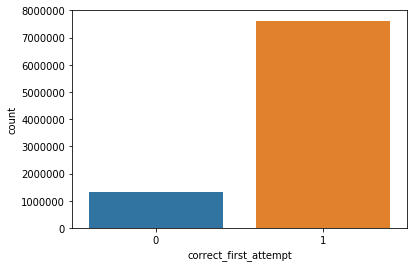

In [5]:
sns.countplot(train['correct_first_attempt'])
plt.show()

Se obtiene la jerarquía del problema. Esta está constituía por dos unidades.

In [6]:
fnames = ['problem_hierarchy1', 'problem_hierarchy2']

train_problem_hierarchy = train.problem_hierarchy.str.split(',', expand=True)
train_problem_hierarchy.columns = fnames
test_problem_hierarchy = test.problem_hierarchy.str.split(',', expand=True)
test_problem_hierarchy.columns = fnames

train = pd.concat([train, train_problem_hierarchy], axis=1)
test = pd.concat([test, test_problem_hierarchy], axis=1)

categorical_features += fnames

train_problem_hierarchy.head()

problem_hierarchy1  problem_hierarchy2
0       Unit CTA1_01   Section CTA1_01-3
1       Unit CTA1_01   Section CTA1_01-3
2       Unit CTA1_01   Section CTA1_01-3
3       Unit CTA1_01   Section CTA1_01-3
4       Unit CTA1_01   Section CTA1_01-3

Codificación de las características categóricas: student_id, problem_name, problem_hierarchy1 y problem_hierarchy2 

In [7]:
encoder = LabelEncoder()
for f in categorical_features:
    encoder.fit(train[f].append(test[f]))
    train[f] = encoder.transform(train[f]).astype('int')
    test[f] = encoder.transform(test[f]).astype('int')

Extracción de características de los componentes de conocimiento:
    
Obtención de matriz dispersa A, formada por N filas y M columnas que representa las oportunidades del estudiante en los componentes de conocimiento requeridos en cada paso.

Cada fila es el paso correspondiente y cada columna es un componente de conocimiento. Solo se almacena el valor de la oportunidad en aquellos componentes requeridos en el paso. Por lo tanto, estas característica tienen el significado de la experiencia que tiene el estudiante en los componentes requeridos por el paso. De esta forma, también se puede extraer información acerca de qué componentes son requeridos en el paso, y no solo la experiencia del estudiante.

In [8]:
max_kcs = 10
kc_names = ['subskills', 'ktracedskills', 'rules']

train_kcs = []
test_kcs = []

for kc_name in tqdm(kc_names):
    kc_col_name = 'kc_{}'.format(kc_name)
    kcop_col_name = 'opp_{}'.format(kc_name)

    # codifica el los diferentes componentes
    train[kc_col_name] = train[[kc_col_name, kcop_col_name]].fillna('')
    test[kc_col_name] = test[[kc_col_name, kcop_col_name]].fillna('')

    train_kc = train[kc_col_name].str.split('~~', expand=True).fillna('')
    test_kc = test[kc_col_name].str.split('~~', expand=True).fillna('')
    
    nkcs = min(max_kcs, train_kc.shape[1], test_kc.shape[1])
    
    train_kc = train_kc.loc[:, :nkcs - 1]
    test_kc = test_kc.loc[:, :nkcs - 1]

    train_kc_stk = train_kc.stack().reset_index(drop=True)
    test_kc_stk = test_kc.stack().reset_index(drop=True)

    kc_stacked = train_kc_stk.append(test_kc_stk)

    encoder = LabelEncoder()
    encoder.fit(kc_stacked)
    for c in range(nkcs):
        train_kc[c] = encoder.transform(train_kc[c])
        test_kc[c] = encoder.transform(test_kc[c])

    # extraer las oportunidades de los componentes
    train_kcop = train[kcop_col_name].str.split('~~', expand=True).fillna(0).loc[:, :nkcs - 1].astype('float')
    test_kcop = test[kcop_col_name].str.split('~~', expand=True).fillna(0).loc[:, :nkcs - 1].astype('float')
    
    # crea matrices dispersas
    train_rows = np.repeat(np.arange(train_kc.shape[0]), train_kc.shape[1])
    test_rows = np.repeat(np.arange(test_kc.shape[0]), test_kc.shape[1])
    train_cols = train_kc.values.reshape(-1)
    test_cols = test_kc.values.reshape(-1)
    train_values = train_kcop.values.reshape(-1)
    test_values = test_kcop.values.reshape(-1)
    
    train_kc_sparse = scipy.sparse.coo_matrix((train_values, (train_rows, train_cols)))
    test_kc_sparse = scipy.sparse.coo_matrix((test_values, (test_rows, test_cols)))
    
    train_kcs.append(train_kc_sparse)
    test_kcs.append(test_kc_sparse)
    

train_kcs = scipy.sparse.hstack(train_kcs, format='csr')
test_kcs = scipy.sparse.hstack(test_kcs, format='csr')

sparse_features += ['kc_{}'.format(i) for i in range(train_kcs.shape[1])]

# libera memoria
del train_rows, test_rows, train_cols, test_cols, train_values, test_values; gc.collect();
del kc_stacked, train_kc_stk, test_kc_stk, train_kc, test_kc, train_kc_sparse, test_kc_sparse; gc.collect();

100%|██████████| 3/3 [11:57<00:00, 239.29s/it]


Muchos componentes están relacionados entre sí, aunque no son exactamente iguales, y normalizarlos requerriría un gran esfuerzo. Por lo tanto, se unen todos los componentes de conocimiento en una cadena de la forma "kc1 kc2 ... kcn". A su vez, cada kci puede estar formado por una frase. Estas cadenas de palabras formadas por la concatenación de componentes de conocimiento, se les aplica un procesamiento de texto básico que consiste en obtener un vector que represente el número de apariciones de cada palabra. De esta forma, unidades de conocimiento con relaciones no consideradas en el paso anterior son ahora descompuestas en palabras permitiendo al algoritmo de aprendizaje buscar interacciones a un más bajo nivel.

In [9]:
def process_kc(kc):
    if kc == '':
        return kc
    kc = [''.join(x.strip().split()) for x in kc if x != '' and 'skillrule' not in x]
    return ' '.join(kc)


kc_names = ['subskills', 'ktracedskills', 'rules']

train_bags = []
test_bags = []
bag_features = []

for kc_name in tqdm(kc_names):
    kc_col_name = 'kc_{}'.format(kc_name)
    
    train_kc_bag = train[kc_col_name].str.split(r'[,(~~);]')
    test_kc_bag = test[kc_col_name].str.split(r'[,(~~);]')
    
    train_kc_bag = train_kc_bag.fillna('')
    test_kc_bag = test_kc_bag.fillna('')
    
    train_kc_bag = train_kc_bag.apply(process_kc)
    test_kc_bag = test_kc_bag.apply(process_kc)
    
    cv = CountVectorizer(ngram_range=(1, 1))
    cv.fit(train[kc_col_name])
    
    train_bag = cv.transform(train_kc_bag)
    test_bag = cv.transform(test_kc_bag)
    
    train_bags.append(train_bag)
    test_bags.append(test_bag)  
    
    bag_features += cv.get_feature_names()

train_bags = scipy.sparse.hstack(train_bags)
test_bags = scipy.sparse.hstack(test_bags)

sparse_features += bag_features

100%|██████████| 3/3 [09:30<00:00, 190.30s/it]


Con el objetivo de obtener característica agregadas: media y desviación típica de errores, pistas, etc, por problema, alumno, unidad, etc. y estas característica no se dan en el conjunto de test, es necesario comprobar si una vez calculadas para el conjunto de entrenamiento se podrán unir al conjunto de test. Para ello, es necesario que el solapamiento entre la característica sobre la que se calculan agregaciones entre el conjunto de entrenamiento y test sea muy alto.

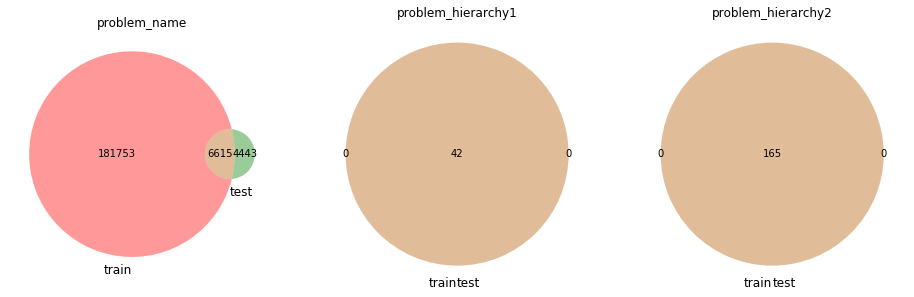

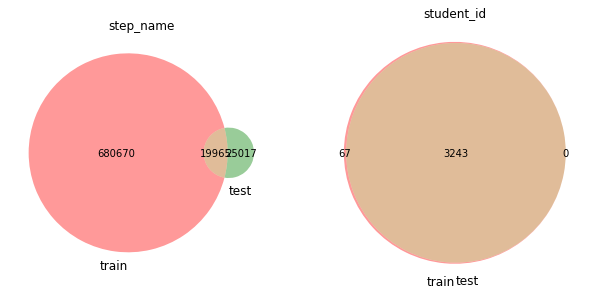

In [10]:
# es posible usar caracteristicas agregadas ?
import matplotlib.pyplot as plt
import seaborn as sns

def get_venn(feature, axarr):
    axarr.set_title(feature)
    venn2([set(train[feature].values), 
           set(test[feature].values)], 
           set_labels = ('train', 'test'), ax=axarr)

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig2, (ax4, ax5) = plt.subplots(1, 2)      
fig1.set_size_inches(16, 7)
fig2.set_size_inches(10.3, 6)     
       
get_venn('problem_name', ax1)
get_venn('problem_hierarchy1', ax2)
get_venn('problem_hierarchy2', ax3)
get_venn('step_name', ax4)
get_venn('student_id', ax5)

Como se observa, puede ser interesante calcular estas características agregadas para todas las características categóricas propuestas. Por lo tanto, se calcula la media y la desviación típica para cada categoria de estas características de los casos correctos, las pistas y los casos incorrectos.

In [11]:
agg_features = ['corrects', 'hints', 'incorrects']

def compute_stats(feature):
    global numeric_features, train, test
    
    mean_names = ['{}_{}_mean'.format(feature, f) for f in agg_features]
    means = train.groupby(feature, as_index=False)[agg_features].mean()
    means.columns = [feature] + mean_names
    
    std_names = ['{}_{}_std'.format(feature, f) for f in agg_features]
    stds = train.groupby(feature, as_index=False)[agg_features].std()
    stds.columns = [feature] + std_names
    
    stats = means.merge(stds, on=feature, how='left')

    train = train.merge(stats, on=feature, how='left')
    test = test.merge(stats, on=feature, how='left')
    
    stats_names = stats.columns.tolist()
    stats_names.remove(feature)
    numeric_features += stats_names
    
compute_stats('problem_hierarchy1')
compute_stats('problem_hierarchy2')
compute_stats('student_id')

Además se calcula el número de pasos que hace un alumno para realizar cada problema

In [12]:
train_student_problem_cnt = train.groupby(['student_id', 'problem_name'], as_index=False)[['row']].count()
test_student_problem_cnt = test.groupby(['student_id', 'problem_name'], as_index=False)[['row']].count()

train_student_problem_cnt = train_student_problem_cnt.rename(columns={'row': 'student_problem_cnt'})
test_student_problem_cnt = test_student_problem_cnt.rename(columns={'row': 'student_problem_cnt'})

train = train.merge(train_student_problem_cnt, on=['student_id', 'problem_name'], how='left')
test = test.merge(test_student_problem_cnt, on=['student_id', 'problem_name'], how='left')

numeric_features += ['student_problem_cnt']

Por cuestiones de memoria se mantienen solo las columnas que se van a utilizar

In [13]:
usecols = ['correct_first_attempt']
usecols += [c for c in train.columns if c in numeric_features or c in categorical_features]
train = train[usecols]
test = test[usecols]
gc.collect();

Se concatenan todas las características extraidas para construir matrices disperas que necesitan menos memoria

In [14]:
features = numeric_features + categorical_features + sparse_features

train_x = scipy.sparse.hstack([train[numeric_features].values,
                               train[categorical_features].values.astype('int'),
                                train_kcs, 
                               train_bags], 
                              format='csr')

test_x = scipy.sparse.hstack([test[numeric_features].values,
                              test[categorical_features].values.astype('int'),
                              test_kcs, 
                              test_bags], 
                             format='csr')

Para validar se sigue el mismo criterio de partición que existe entre el conjunto de entrenamiento y el de test. De cada estudiante se selecciona solo el último problema para el conjunto de validación, dejando todos los anteriores en el conjunto de test. 

In [15]:
valid_keys = train[['student_id', 'problem_name']].groupby('student_id', as_index=False).last()
valid_keys = valid_keys.sample(400)
print('Se valida con {} problemas'.format(valid_keys.shape[0]))

mask_student_valid = train['student_id'].isin(valid_keys['student_id']).values
mask_problem_valid = train['problem_name'].isin(valid_keys['problem_name']).values
valid_mask = mask_student_valid & mask_problem_valid

valid_indices = np.where(valid_mask)[0]
train_indices = np.where(~valid_mask)[0]

valid_keys.head()

Se valida con 400 problemas


student_id  problem_name
870          870            75
1460        1460        185058
944          944        192429
2987        2987          5619
1467        1467        188734

In [16]:
valid_x = train_x[valid_indices]
train_x = train_x[train_indices]

valid_y = train.loc[valid_mask, 'correct_first_attempt'].values
train_y = train.loc[~valid_mask, 'correct_first_attempt'].values

del train, test; gc.collect();

In [17]:
print('train: {}'.format(train_x.shape))
print('valid: {}'.format(valid_x.shape))

train: (8699552, 3596)
valid: (218502, 3596)


Una vez se tienen preparados los datos, se ajusta el modelo que consiste en un algoritmo de boosting de árboles. Concretamente la librería utilizada es LightGradientBoosting.

In [18]:
params = {
    'metric': 'rmse',
    'learning_rate': 0.15,
    'application': 'regression',
    'max_depth': 12,
    'num_leaves': 64,
    'data_random_seed': 32,
    'bagging_fraction': 0.9,
    'bagging_freq': 2,
    'feature_fraction': 0.7,
    'nthread': 8
}

lgtrain = lgb.Dataset(train_x, train_y, feature_name=features, categorical_feature=categorical_features)
lgvalid = lgb.Dataset(valid_x, valid_y, feature_name=features, categorical_feature=categorical_features)

lgb_clf = lgb.train(
    params,
    lgtrain,
    categorical_feature=categorical_features,
    num_boost_round=7000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=50,
    verbose_eval=50)

/home/pablo/anaconda2/envs/ml/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[50]	train's rmse: 0.314198	valid's rmse: 0.33085
[100]	train's rmse: 0.309196	valid's rmse: 0.326544
[150]	train's rmse: 0.306264	valid's rmse: 0.324741
[200]	train's rmse: 0.303963	valid's rmse: 0.323485
[250]	train's rmse: 0.302217	valid's rmse: 0.322486
[300]	train's rmse: 0.30069	valid's rmse: 0.321576
[350]	train's rmse: 0.299436	valid's rmse: 0.320851
[400]	train's rmse: 0.298171	valid's rmse: 0.320348
[450]	train's rmse: 0.297248	valid's rmse: 0.319846
[500]	train's rmse: 0.296185	valid's rmse: 0.319622
[550]	train's rmse: 0.295427	valid's rmse: 0.319314
[600]	train's rmse: 0.294699	valid's rmse: 0.319003
[650]	train's rmse: 0.294017	valid's rmse: 0.318817
[700]	train's rmse: 0.29341	valid's rmse: 0.318505
[750]	train's rmse: 0.292843	valid's rmse: 0.318408
[800]	train's rmse: 0.292262	valid's rmse: 0.318117
[850]	train's rmse: 0.291772	valid's rmse: 0.318009
[900]	train's rmse: 0.291326	valid's rmse: 0.317909
[950]	

Se muestra la importancia de cada característica

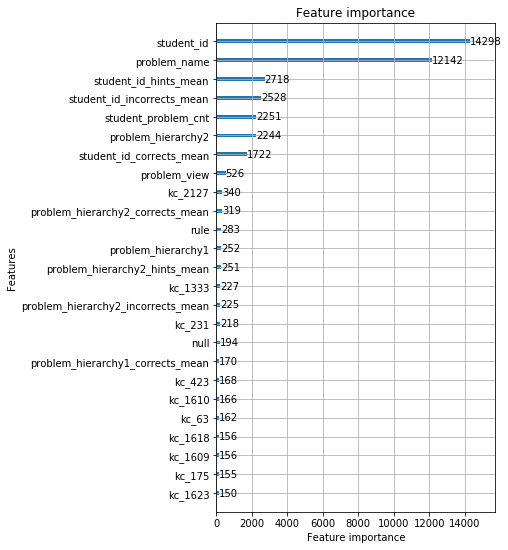

In [19]:
lgb.plot_importance(lgb_clf, max_num_features=25, figsize=(5, 9))
plt.show()

Se realizan las predicciones y se prepara el archivo submission

In [20]:
test_pred = lgb_clf.predict(test_x)
score = lgb_clf.best_score['valid']['rmse']

sub_path = 'submissions/algebra_2008_2009_submission.csv'

sub['Correct First Attempt'] = test_pred
sub['Correct First Attempt'] = sub['Correct First Attempt'].clip(0, 1)
sub.to_csv(sub_path, index=False, sep='\t')
zipf = zipfile.ZipFile('submissions/{}.zip'.format(round(score, 4)), 'w', zipfile.ZIP_DEFLATED)
zipf.write(sub_path, os.path.basename(sub_path))
zipf.close()

Y por último, se comprueba que las predicciones están en el rango deseado y su distribución

/home/pablo/anaconda2/envs/ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


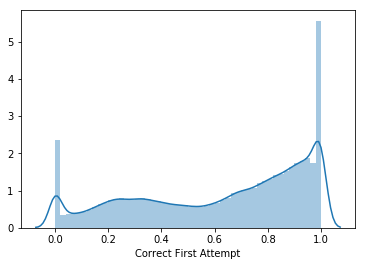

In [21]:
sns.distplot(sub['Correct First Attempt'])
plt.show()